In [82]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from models import DeepConditionalModel, InvariantNetwork
from inn_utils import train_loop_dataset
from viz import plot_true_est_scatter, plot_true_est_posterior, plot_losses

In [50]:
np.set_printoptions(suppress=True)

In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Data loader for seqRNA matrices

In [14]:
class RNADataLoader:
    """A class to sequentially load batches of seq RNA matrices."""
    def __init__(self, batch_size=32, data_path='.', normalize=True, 
                 shuffle=True, n_cells=100, n_genes=100, n_sim_chunk=5000):
        
        self.data_path = data_path
        self._batch_size = batch_size
        self._n_cells = n_cells
        self._n_genes = n_genes
        self._n_sim = n_sim_chunk
        self._idx = 0
        self._normalize = normalize
        self._shuffle = shuffle
        self._num_chunks = self._get_num_chunks()
        self._data_files_list = self._get_data_files()
        self._param_files_list = self._get_param_files()
        assert len(self._data_files_list) == len(self._param_files_list), '# Data files in {} must equal # params files'.format(self.path)
        
        self._global_max = 0
        # This takes time
        if self._normalize:
            self._get_global_max()        
        if self._shuffle:
            self._shuffle_chunks()

    
    def _shuffle_chunks(self):
        """Shuffles the order of the chunks."""

        self._data_files_list, self._param_files_list = shuffle(self._data_files_list, self._param_files_list)
    
    def _get_num_chunks(self):
        
        return len(os.listdir(os.path.join(self.data_path, 'data'))) 
    
    def _get_data_files(self):
        
        return [os.path.join(self.data_path, 'data', f) 
                for f in os.listdir(os.path.join(self.data_path, 'data'))]
    
    def _get_param_files(self):
        
        return [os.path.join(self.data_path, 'params', f) 
                for f in os.listdir(os.path.join(self.data_path, 'params'))]
    
    def _get_global_max(self):
        """Determines the global maximum count over all counts dataset."""
        
        self._global_max = 0
        for data_file in self._data_files_list:
            X = np.load(data_file).astype(np.float32)
            max_count = np.max(X)
            if max_count > self._global_max:
                self._global_max = max_count
        print('Global max determined: ', self._global_max)
            
    
    def load_test(self, n_test, path='.', to_tensor=True):
        """Loads a test dataset."""
        
        X = np.load(os.path.join(path, 'test', 'rna_data_test.npy')).astype(np.float32)
        y = np.load(os.path.join(path, 'test', 'rna_params_test.npy')).astype(np.float32)
        X = X.reshape(self._n_genes, self._n_cells, n_test).T
        if to_tensor:
            X, y = tf.convert_to_tensor(X), tf.convert_to_tensor(y)
        return X, y
    
    def _load_next(self):
        """Loads the current data files."""
        
        # Make sure a corresponding pair of data-params is loaded
        data_file = self._data_files_list[self._idx]
        params_file = self._param_files_list[self._idx]
        assert data_file.split('_')[-1] == params_file.split('_')[-1]
        
        # Load as numpy
        X = np.load(data_file).astype(np.float32)
        y = np.load(params_file).astype(np.float32)
        
        # Convert to N_sim x Genes x Cells tensor
        X = X.reshape(self._n_genes, self._n_cells, self._n_sim).T
        
        # Normalize
        if self._normalize:
            X /= self._global_max
        
        # Create a tf dataset
        dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(X.shape[0]).batch(self._batch_size)

        # Increment index and return dataset
        self._idx = self._idx + 1
        return dataset
    
    def __iter__(self): 
        return self
    
    def __next__(self):
        # Increment index and check if we are at the end of the file list 
        if self._idx == self._num_chunks:
            self._idx = 0
            if self._shuffle:
                self._shuffle_chunks()
            raise StopIteration
        return self._load_next()

In [5]:
def remove_implausible(X_batch, theta_batch, zeros_tolerated=1000):
    """Removes implausible simulated matrices from batch."""
    
    plausible = tf.reduce_sum(tf.cast(tf.equal(X_batch, 0.), tf.int32), axis=(1, 2)) < zeros_tolerated
    X_batch_plausible = tf.boolean_mask(X_batch, plausible, axis=0)
    theta_batch_plausible = tf.boolean_mask(theta_batch, plausible, axis=0)
    return X_batch_plausible, theta_batch_plausible

# Initialization 

In [23]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
param_names = ['alpha', 'beta', 'out_loc', 'out_scale', 
               'lib_loc', 'lib_scale', 'out_prob', 'bcv']
theta_dim = 8
summary_dim = 128
x_dim = 100
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 32
epochs = 10
n_inv_blocks = 10
data_path = 'D:\\seqRNA'
n_samples_posterior = 2000
verbose_each = 100
starter_learning_rate = 0.001
decay_steps = 7800
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

# --- Data loader --- #
n_chunks = 50
n_sim_chunk = 5000
data_loader  = RNADataLoader(batch_size, data_path, normalize=False, n_sim_chunk=n_sim_chunk)

## Create a test set

In [24]:
X_test, theta_test = data_loader.load_test(n_test=500, path=data_path)
data_loader._global_max = np.max(X_test.numpy())
data_loader._normalize = True

In [25]:
X_test_plausible, theta_test_plausible = remove_implausible(X_test, theta_test, 1000)
X_test_plausible /= data_loader._global_max

## Create networks

In [26]:
summary_net = InvariantNetwork(summary_dim, n_equiv=3)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Checkpoint manager

In [33]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/seqrna', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


## Plot performance of untrained model

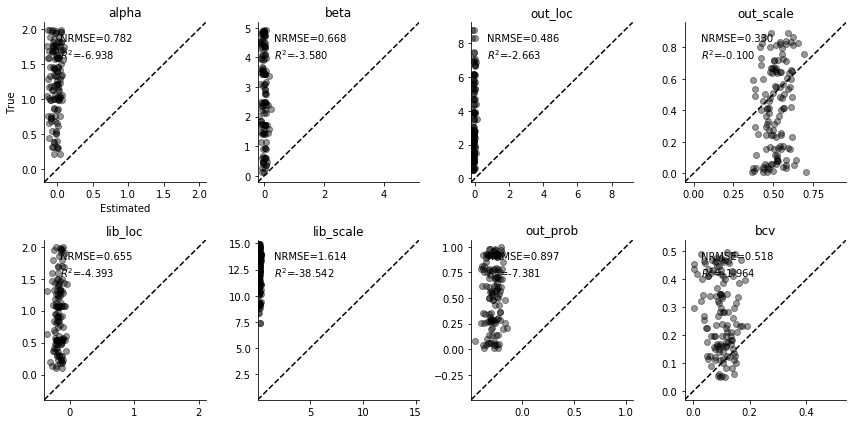

In [28]:
plot_true_est_scatter(model, X_test_plausible, theta_test_plausible, 
                      n_samples_posterior, param_names, figsize=(12, 6))

# Train the model

Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...



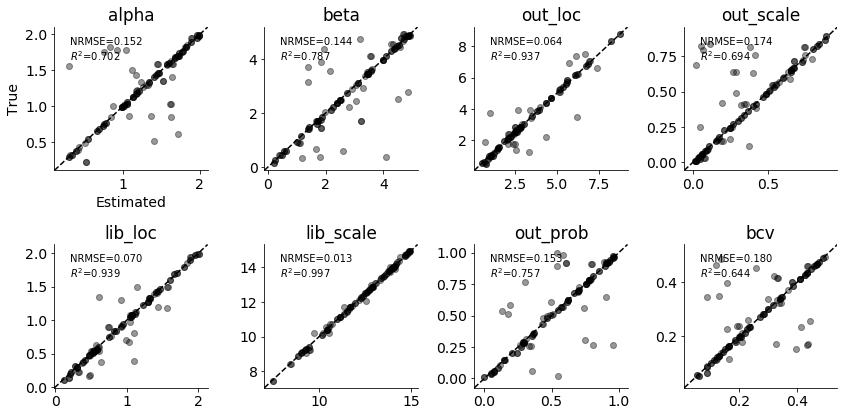

Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...



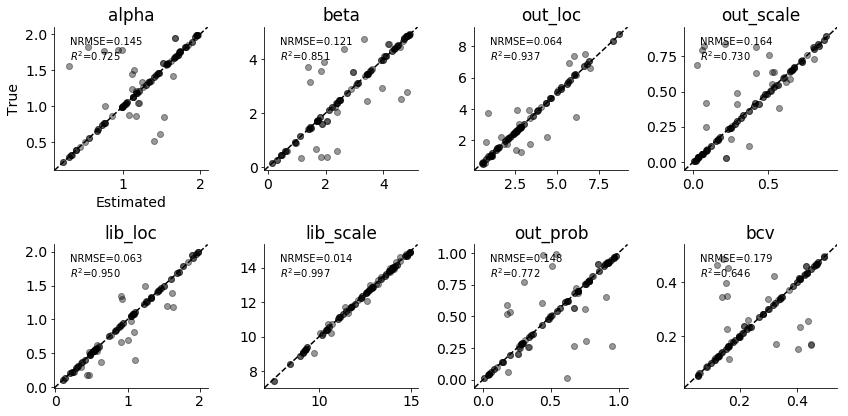

Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...



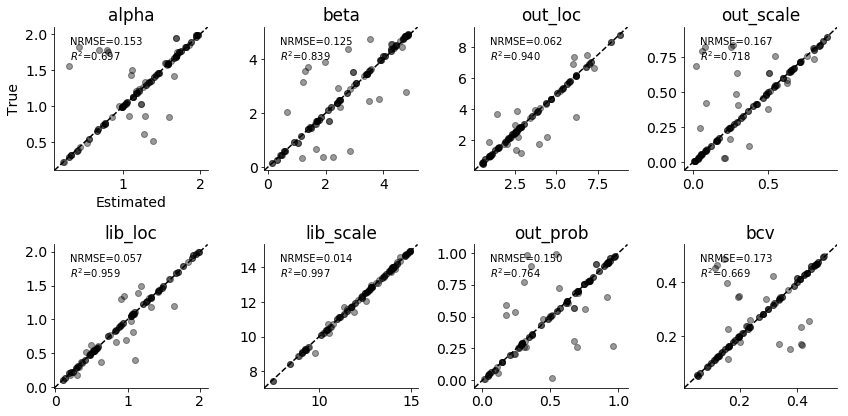

Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...



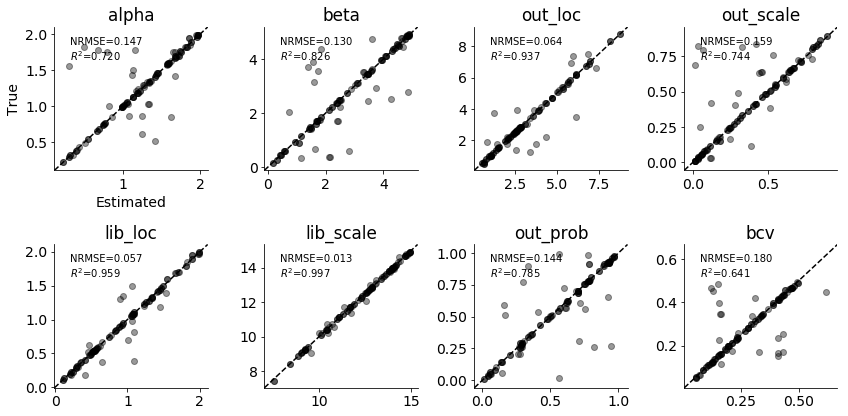

Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...



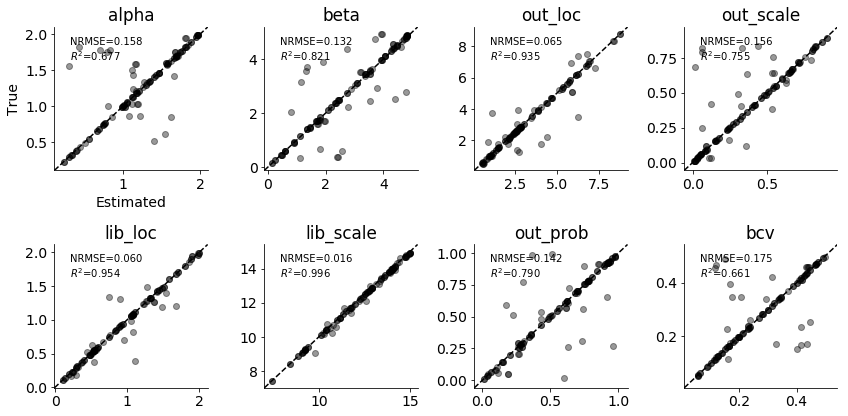

Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...



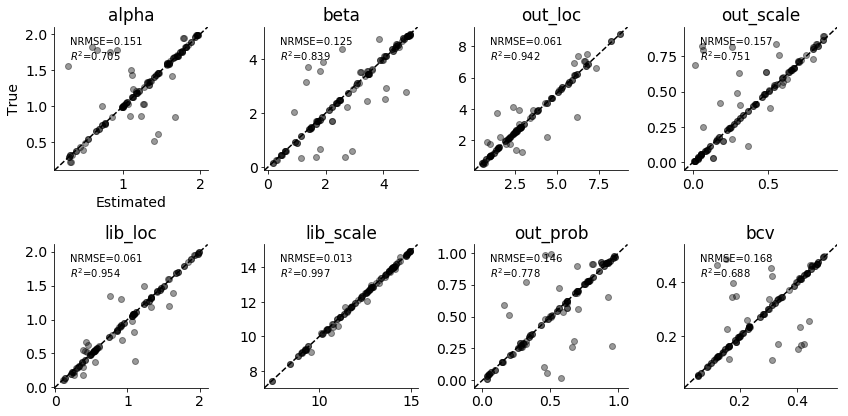

Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...
Iteration produced empty tensor, skipping...



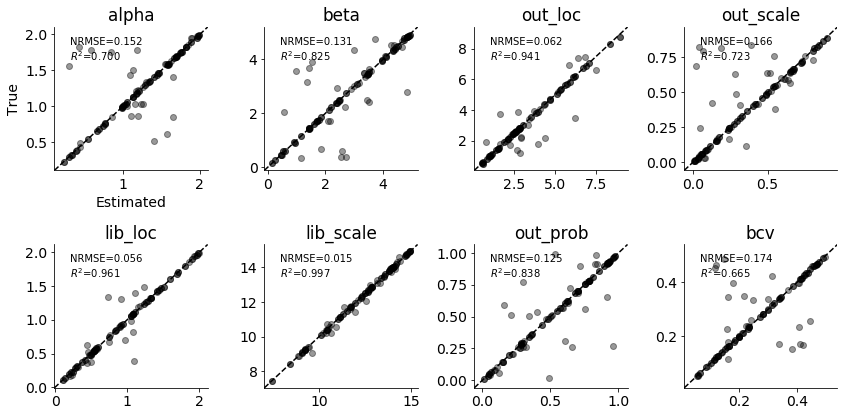

KeyboardInterrupt: 

In [38]:
for ep in range(1, epochs+1):
    with tqdm(total=n_chunks * n_sim_chunk // batch_size, desc='Epoch {}'.format(ep)) as p_bar:
        # One loop over the chunk
        for chunk in data_loader:
            losses = train_loop_dataset(model, optimizer, chunk, batch_size, p_bar, 
                                        clip_value=clip_value, global_step=global_step, 
                                        transform=remove_implausible)

    # Plot recovery
    plot_true_est_scatter(model, X_test_plausible, theta_test_plausible, 
              n_samples_posterior, param_names, figsize=(12, 6))
    # Save model
    manager.save()

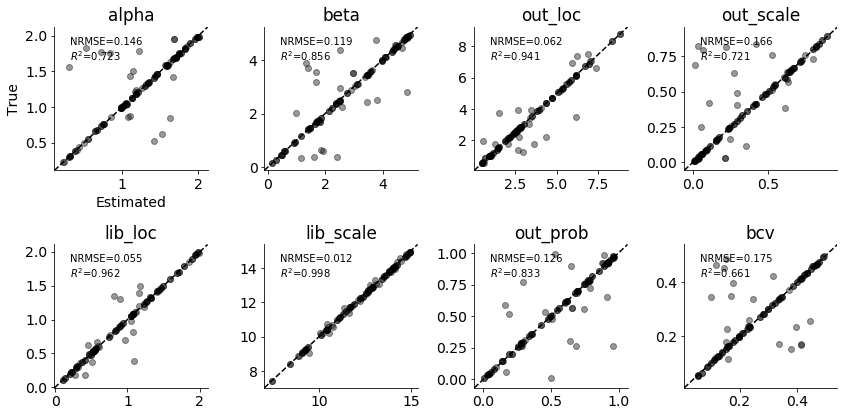

In [57]:
plot_true_est_scatter(model, X_test_plausible, theta_test_plausible, 
                      n_samples_posterior, param_names, figsize=(12, 6))

In [68]:
c = np.corrcoef(theta_hat, rowvar=False)

In [88]:
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False,  True]])

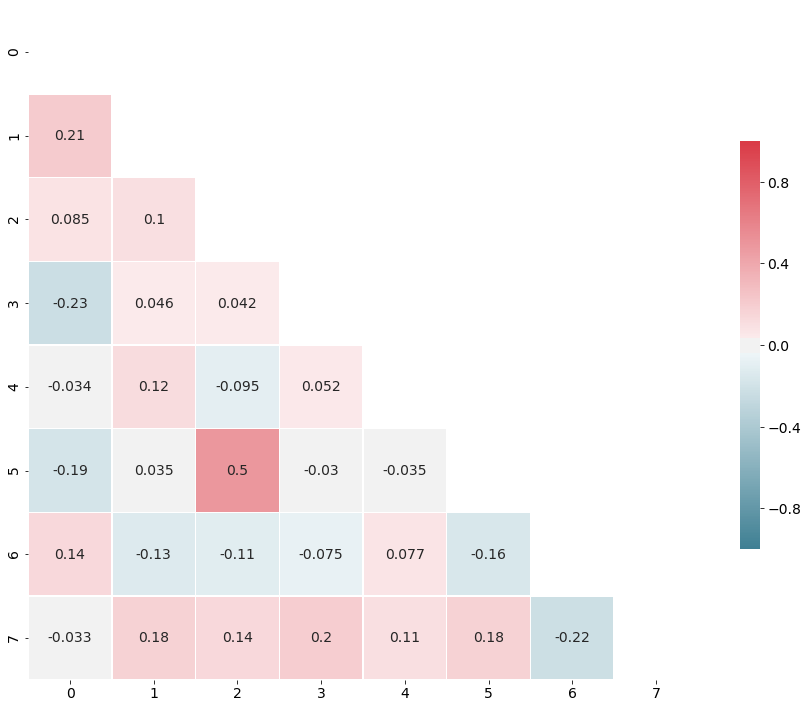

In [92]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))

# Generate a mask for the upper triangle
mask = np.zeros_like(c, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(c, cmap=cmap, mask=mask, vmax=np.max(c), vmin=-np.max(c), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, ax=ax)

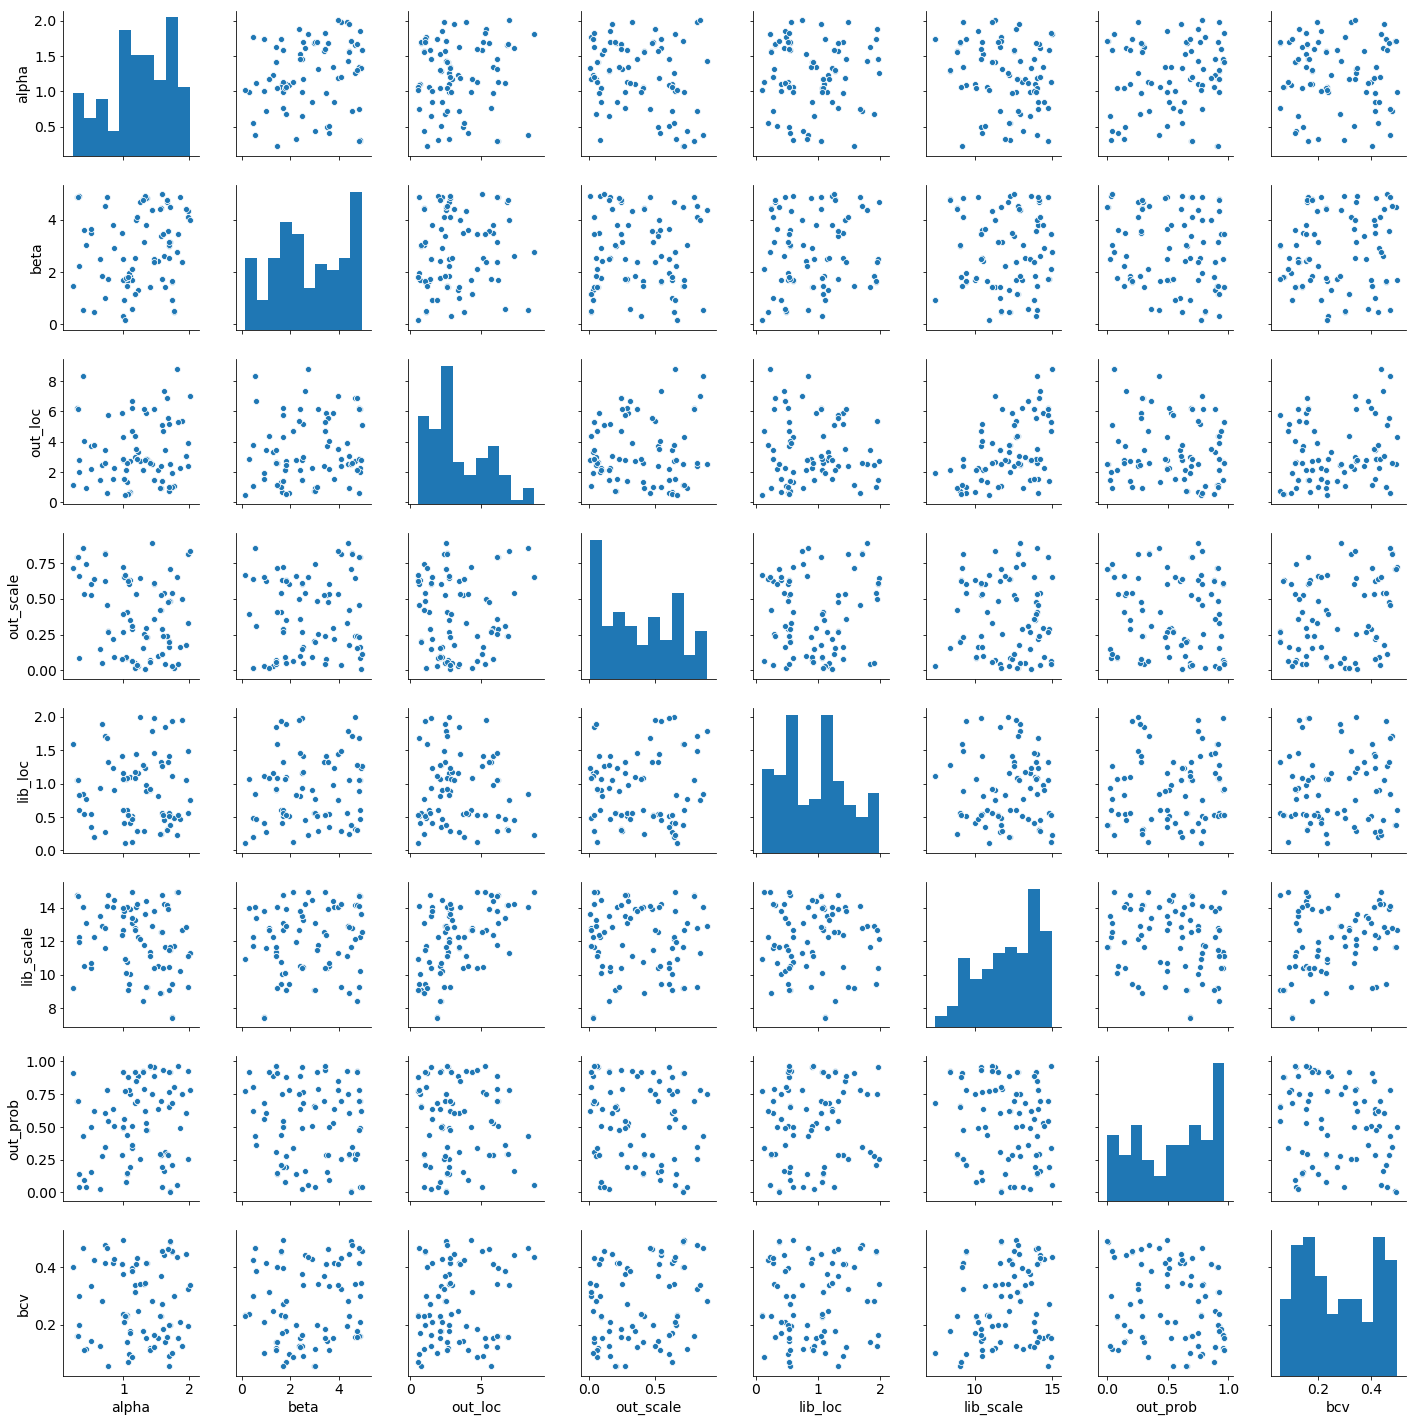

In [84]:
sns.pairplot(pd.DataFrame(theta_hat, columns=param_names))